In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_friedman3
import optuna

EPOCHS = 100

tf.random.set_seed(17)

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PrintLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % 10 == 0:
            print(f'Epoch {epoch}: Loss = {logs["loss"]:.4f}, R_square = {logs["r_square"]:.4f}, MSE = {logs["mean_squared_error"]:.4f}, \
                  \n Val Loss = {logs["val_loss"]}, Val R Square = {logs["val_r_square"]}, Val MSE = {logs["val_mean_squared_error"]} \n')

# 2 датасет

Оскільки аргументи не вказані, то я їх вибрав самотужки: 

In [3]:
X_data, y_data = make_friedman3(n_samples=100, noise=0.1, random_state=17)

X_data = pd.DataFrame(X_data, columns=['x1', 'x2', 'x3', 'x4'])

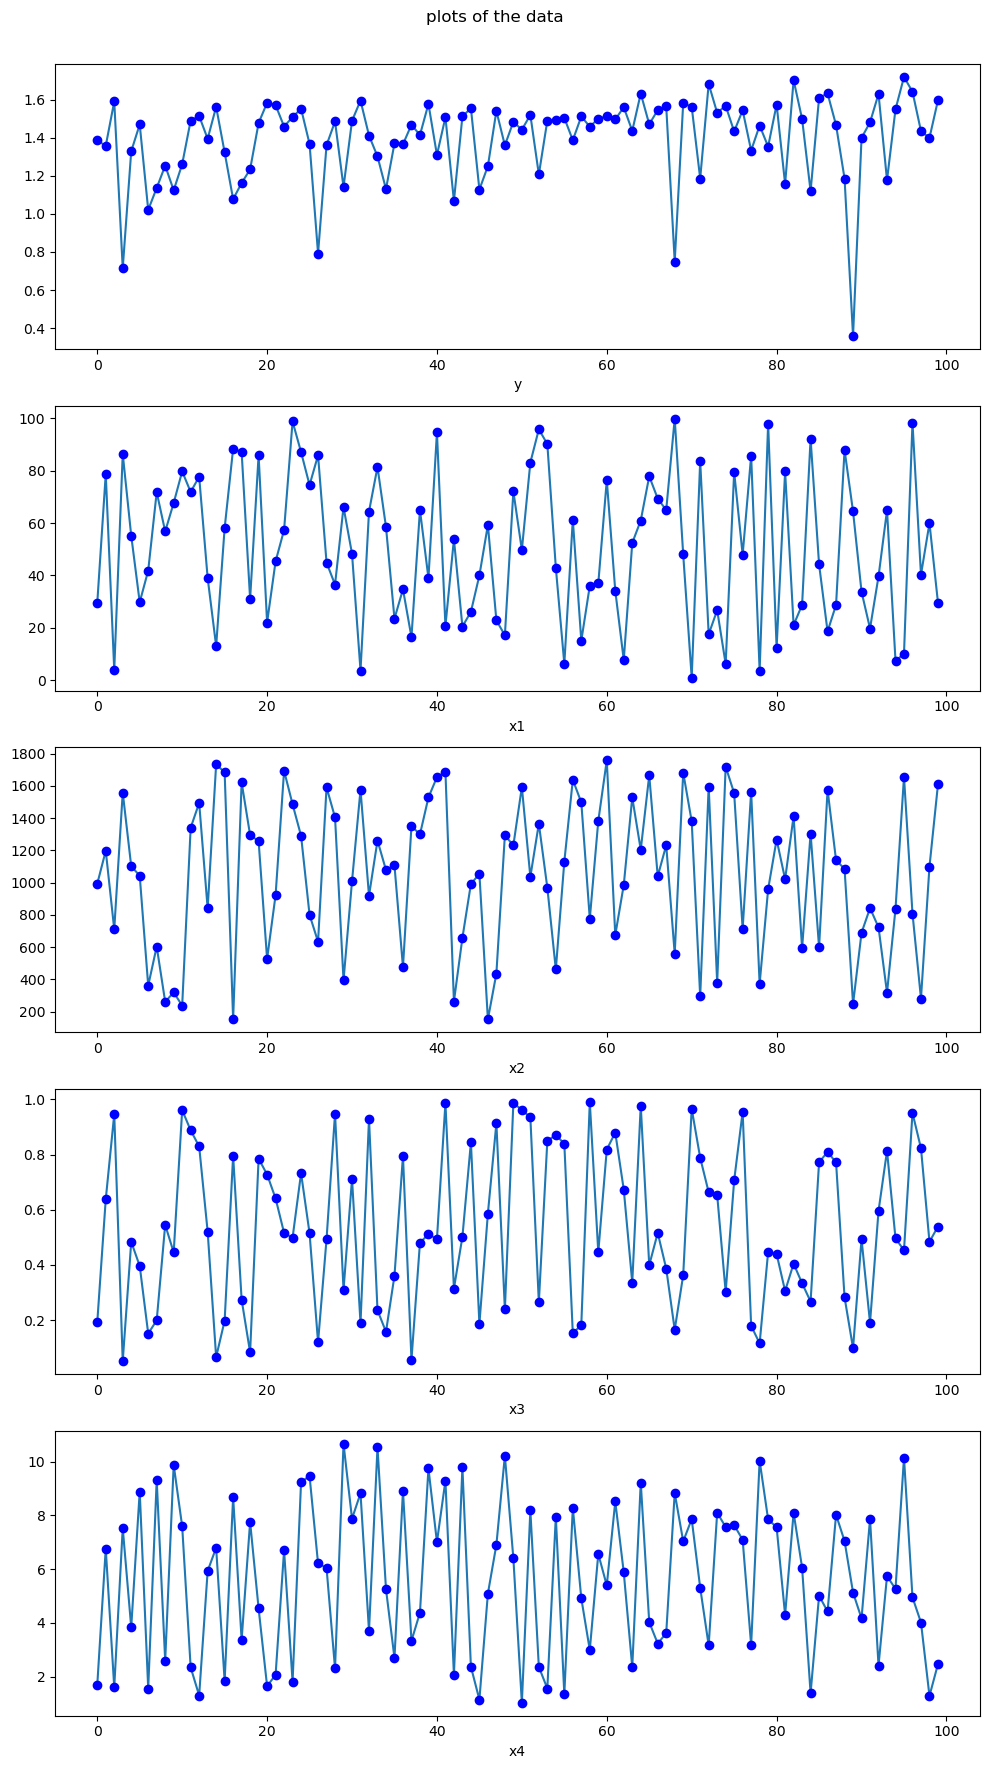

In [4]:
fig, axs = plt.subplots(5, 1, figsize=(10, 18))

axs[0].plot(y_data)
axs[0].plot(y_data, 'bo')
axs[0].set_xlabel('y')

axs[1].plot(X_data['x1'])
axs[1].plot(X_data['x1'], 'bo')
axs[1].set_xlabel('x1')

axs[2].plot(X_data['x2'])
axs[2].plot(X_data['x2'], 'bo')
axs[2].set_xlabel('x2')

axs[3].plot(X_data['x3'])
axs[3].plot(X_data['x3'], 'bo')
axs[3].set_xlabel('x3')

axs[4].plot(X_data['x4'])
axs[4].plot(X_data['x4'], 'bo')
axs[4].set_xlabel('x4')

fig.suptitle('plots of the data')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

Оскільки тут цікава задача яка створює регресію з 4 вхідних даних, я буду використовувати як степінь поліному - 2

In [5]:
DEGREE_2 = 2

# Ділимо дані

Оскільки нам потім потрібно буде підбирати значення гіперпараметрів: регуляризації та швидкості навчання то розбивати будемо на 3 набори даних

Також важливим кроком тут буде стандартизація вхідних даних через дуже високу різницю між їх масштабами, та і стандартизація цільової також буде важливим кроком

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=17)

stdscaler = StandardScaler()

X_train = pd.DataFrame(stdscaler.fit_transform(X_train), columns=stdscaler.get_feature_names_out())
X_train_val = pd.DataFrame(stdscaler.transform(X_train_val), columns=stdscaler.get_feature_names_out())
X_test = pd.DataFrame(stdscaler.transform(X_test), columns=stdscaler.get_feature_names_out())
X_val = pd.DataFrame(stdscaler.transform(X_val), columns=stdscaler.get_feature_names_out())
X_data = pd.DataFrame(stdscaler.transform(X_data), columns=stdscaler.get_feature_names_out())

y_stdscaler = StandardScaler()

y_train = y_stdscaler.fit_transform(y_train.reshape(-1, 1))
y_train_val = y_stdscaler.transform(y_train_val.reshape(-1, 1))
y_test = y_stdscaler.transform(y_test.reshape(-1, 1))
y_val = y_stdscaler.transform(y_val.reshape(-1, 1))
y_data = y_stdscaler.transform(y_data.reshape(-1, 1))


Подивимось на результат стандартизації

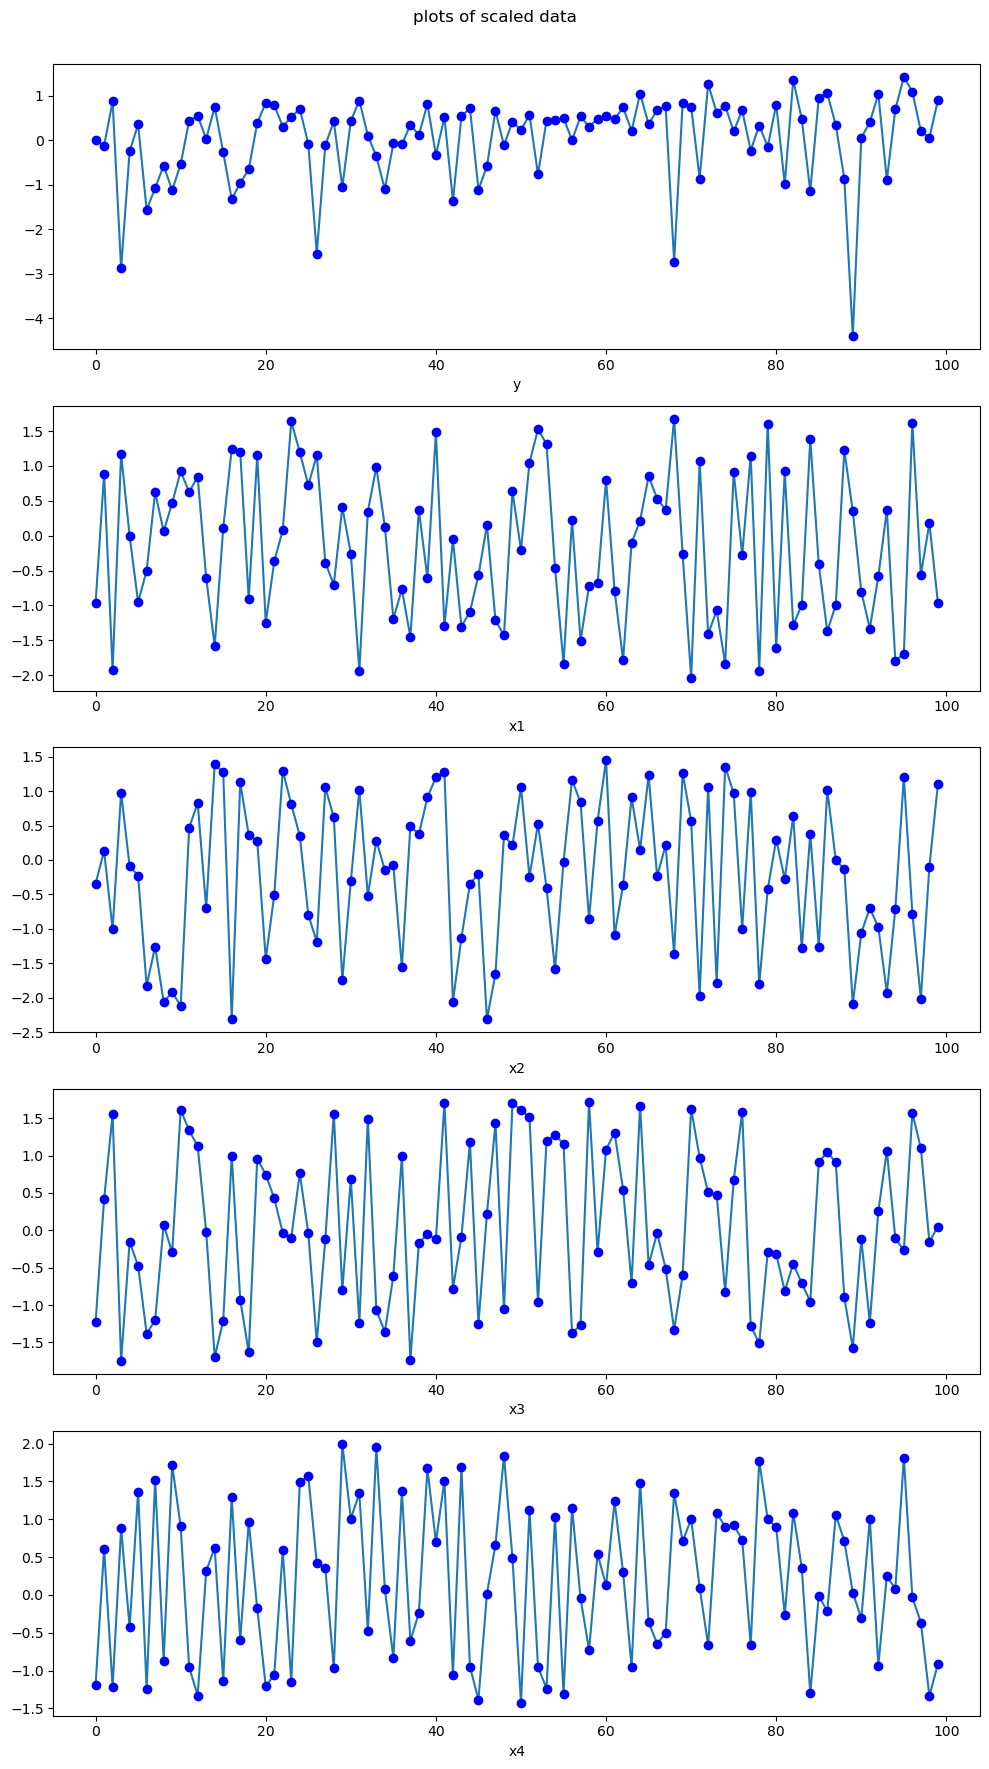

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(10, 18))

axs[0].plot(y_data)
axs[0].plot(y_data, 'bo')
axs[0].set_xlabel('y')

axs[1].plot(X_data['x1'])
axs[1].plot(X_data['x1'], 'bo')
axs[1].set_xlabel('x1')

axs[2].plot(X_data['x2'])
axs[2].plot(X_data['x2'], 'bo')
axs[2].set_xlabel('x2')

axs[3].plot(X_data['x3'])
axs[3].plot(X_data['x3'], 'bo')
axs[3].set_xlabel('x3')

axs[4].plot(X_data['x4'])
axs[4].plot(X_data['x4'], 'bo')
axs[4].set_xlabel('x4')

fig.suptitle('plots of scaled data')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

In [8]:
poly = PolynomialFeatures(degree=DEGREE_2)

X_train = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out())
X_train_val = poly.transform(X_train_val)
X_test = poly.transform(X_test)
X_val = poly.transform(X_val)
X_data = poly.transform(X_data)

X_tens = tf.constant(X_data, dtype=tf.float32)
y_tens = tf.constant(y_data, dtype=tf.float32)

X_tens_train = tf.constant(X_train, dtype=tf.float32)
X_tens_train_val = tf.constant(X_train_val, dtype=tf.float32)
X_tens_test = tf.constant(X_test, dtype=tf.float32)
X_tens_val = tf.constant(X_val, dtype=tf.float32)

y_tens_train = tf.constant(y_train, dtype=tf.float32)
y_tens_train_val = tf.constant(y_train_val, dtype=tf.float32)
y_tens_test = tf.constant(y_test, dtype=tf.float32)
y_tens_val = tf.constant(y_val, dtype=tf.float32)

## Функції для Optuna з ініціалізацією моделі

Оскільки Optuna на даний момент це одна з найкращих бібліотек для оптимізацї гіперпараметрів, то використовувати будемо її

Спочатку нам потрібно вказати які гіперпараметри налаштовувати, у нашому випадку це регуляризація та швидкість навчання

Потім ми ініціалізуємо саму модель із цими гіперпараметрами, навчаємо її і функції самотужки підбирає їх значення через баєсівську оптимізацію

Також оскільки у нас йде паралельне навчання декількох моделей я виставив verbose = 0

Навчати будемо на навчальному та валідаційному наборі даних

*код для ініціалізації був взятий [тут](https://github.com/optuna/optuna-examples/blob/main/keras/keras_simple.py)*

In [9]:
def objective(trial):
    
    c_lambda_1 = trial.suggest_float("lambda_1", 1e-5, 1, log=True)
    c_lambda_2 = trial.suggest_float("lambda_2", 1e-5, 1, log=True)
    lrng_rate = trial.suggest_float("lrng_rate", 1e-5, 1, log=True)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20, activation='relu', input_shape=(X_tens_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(c_lambda_1)),
        tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(c_lambda_2)),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrng_rate),
            loss='mean_squared_error',
            metrics = [tfa.metrics.RSquare(), tf.keras.metrics.MeanSquaredError()])

    model.fit(X_tens_train, y_tens_train,
                    epochs=EPOCHS,
                    verbose=0,
                    validation_data=(X_tens_val, y_tens_val))

    score = model.evaluate(X_tens_val, y_tens_val, verbose=0)
    return score[0]

In [10]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=20, timeout=600, n_jobs=-1)

[I 2023-06-02 14:06:11,434] A new study created in memory with name: no-name-f2180c19-7e60-4c6b-ba61-377d42f3de71


[I 2023-06-02 14:06:28,329] Trial 0 finished with value: 0.22123916447162628 and parameters: {'lambda_1': 0.18359856698585383, 'lambda_2': 0.0002344752181355957, 'lrng_rate': 0.006044771050175126}. Best is trial 0 with value: 0.22123916447162628.
[I 2023-06-02 14:06:28,356] Trial 1 finished with value: 0.23169595003128052 and parameters: {'lambda_1': 1.6982596900658317e-05, 'lambda_2': 0.6247084926459069, 'lrng_rate': 0.011754766609485724}. Best is trial 0 with value: 0.22123916447162628.
[I 2023-06-02 14:06:29,046] Trial 4 finished with value: 17.060361862182617 and parameters: {'lambda_1': 0.08274325184709284, 'lambda_2': 0.9992895306896739, 'lrng_rate': 0.00012230234901929862}. Best is trial 0 with value: 0.22123916447162628.
[I 2023-06-02 14:06:29,055] Trial 3 finished with value: 2.8688137531280518 and parameters: {'lambda_1': 0.16698657022637625, 'lambda_2': 0.000338684470267943, 'lrng_rate': 0.00022656169286709114}. Best is trial 0 with value: 0.22123916447162628.
[I 2023-06-02 

In [11]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.1119755357503891
  Params: 
    lambda_1: 0.028002000244883734
    lambda_2: 3.373699285093832e-05
    lrng_rate: 0.029669741492412274


Навчимо модель на більшому наборі даних з найкращими значеннями гіперпараметрів які ми отримали після їх підбору

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(X_tens_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.028)),
    tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00003)),
    tf.keras.layers.Dense(1)
])
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss='mean_squared_error',
              metrics=[tfa.metrics.RSquare(), tf.keras.metrics.MeanSquaredError()])

history = model.fit(X_tens_train_val, y_tens_train_val,
                    epochs=EPOCHS,
                    callbacks=[PrintLossCallback(),
                               tf.keras.callbacks.ModelCheckpoint(filepath="model_isprr2_2",
                                                                  save_best_only=True, verbose=0,
                                                                  save_weights_only=True)],
                    verbose=0,
                    validation_data=(X_tens_test, y_tens_test))

y_pred_test = model.predict(X_tens_test)
y_pred_full = model.predict(X_tens)

Epoch 0: Loss = 1.4389, R_square = -0.0532, MSE = 1.0232,                   
 Val Loss = 0.7128767967224121, Val R Square = 0.3757634162902832, Val MSE = 0.3585774600505829 

Epoch 10: Loss = 0.2490, R_square = 0.8730, MSE = 0.1234,                   
 Val Loss = 0.3299880027770996, Val R Square = 0.6275207996368408, Val MSE = 0.21396157145500183 

Epoch 20: Loss = 0.1316, R_square = 0.9199, MSE = 0.0779,                   
 Val Loss = 0.2426626980304718, Val R Square = 0.6676038503646851, Val MSE = 0.1909368336200714 

Epoch 30: Loss = 0.1481, R_square = 0.8940, MSE = 0.1030,                   
 Val Loss = 0.2110225260257721, Val R Square = 0.7075915336608887, Val MSE = 0.16796690225601196 

Epoch 40: Loss = 0.1068, R_square = 0.9319, MSE = 0.0662,                   
 Val Loss = 0.3244192600250244, Val R Square = 0.5039668083190918, Val MSE = 0.2849341332912445 

Epoch 50: Loss = 0.1041, R_square = 0.9275, MSE = 0.0705,                   
 Val Loss = 0.2716823220252991, Val R Square =

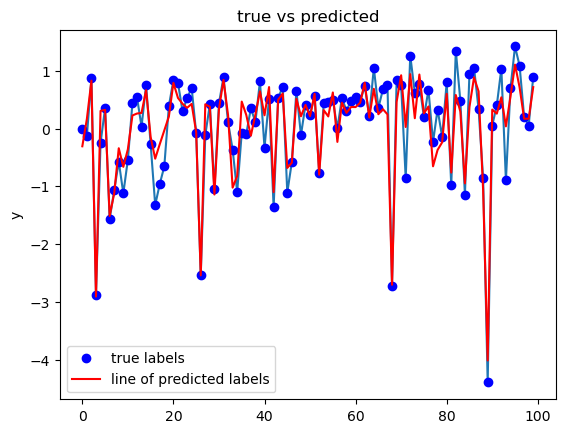

In [17]:
plt.plot(y_data)
plt.plot(y_data, 'bo', label='true labels')

plt.plot(y_pred_full, c='red', label='line of predicted labels')

plt.title('data plot')
plt.ylabel('y')
plt.title('true vs predicted')
plt.legend()

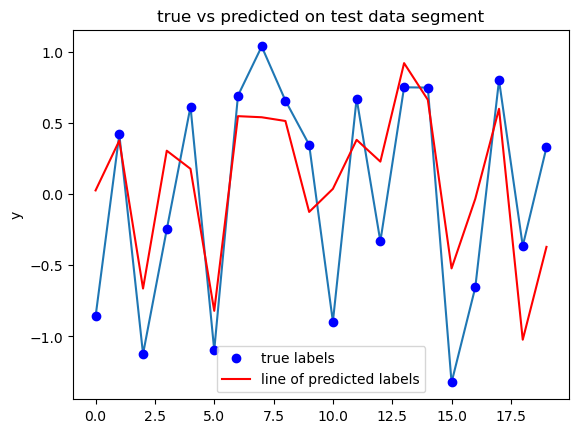

In [18]:
plt.plot(y_tens_test.numpy())
plt.plot(y_tens_test.numpy(), 'bo', label='true labels')

plt.plot(y_pred_test, c='red', label='line of predicted labels')

plt.title('data plot')
plt.ylabel('y')
plt.title('true vs predicted on test data segment')
plt.legend()

Як ми бачимо модель отримала відносно високі показники метрик як для навчальної вибірки так і для тестової, і ми отримали досить близький графік до справжніх значень

Відносно тому що значення R^2 для тестової вибірки не дуже високе

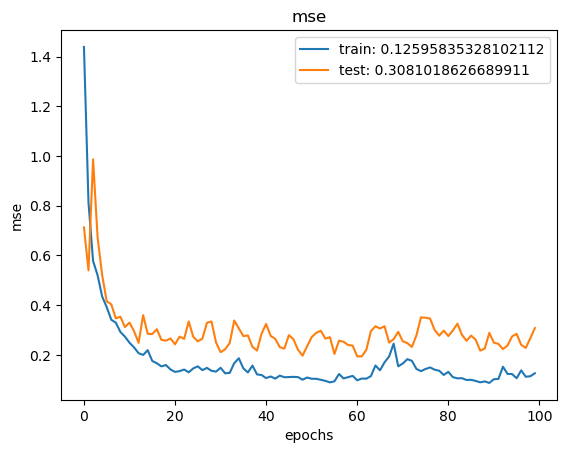

In [19]:
plt.plot(history.history['loss'], label=f"train: {history.history['loss'][-1]}")
plt.plot(history.history['val_loss'], label=f"test: {history.history['val_loss'][-1]}")
plt.xlabel("epochs")
plt.ylabel("mse")
plt.title('mse')
plt.legend()
plt.show()

Як ми бачимо значення нашої функції втрат стабільно йшло вниз